### Import libraries

In [2]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from arch import arch_model
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timezone
from scipy.stats import beta, linregress
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import time
from tqdm import tqdm
import os
import glob

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {DEVICE}")
if DEVICE.type == "cuda":
    print(f"GPU Name; {torch.cuda.get_device_name(0)}")

OSError: [WinError 126] 지정된 모듈을 찾을 수 없습니다. Error loading "c:\Users\kjw02\anaconda3\Lib\site-packages\torch\lib\backend_with_compiler.dll" or one of its dependencies.

### Data Preparation Function

In [2]:
def download_btc_data(start_year, end_year, timeframe, symbol = 'BTC/USDT'):
    """
    Args:
        start_year (int): 시작 연도
        end_year (int): 종료 연도
        timeframe (str): 데이터 간격 ('1m', '10m' ,'1d')
        symbol (str): 코인 심볼 (기본 BTC/USDT)
    """
    
    save_dir = "data"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"[INFO] Directory '{save_dir}' created")

    # Create Binance object
    binance = ccxt.binance({
        'enableRateLimit': True,
        'options': {'defaultType': 'future'}
    })

    # Check wheather Binance support timeframe
    if timeframe not in binance.timeframes:
        print(f"[ERROR] '{timeframe} is not a valid timeframe")
        return

    print(f"Target: {symbol} | Timeframe: {timeframe} | Period: {start_year} ~ {end_year}")
    
    safe_symbol = symbol.replace("/", "")

    for year in range(start_year, end_year + 1):
        # Set file path including data folder
        filename = f"{safe_symbol}_{timeframe}_{year}.csv"
        file_path = os.path.join(save_dir, filename)
        
        # Check file existence
        if os.path.exists(file_path):
            print(f"[SKIP] '{filename}' already exists")
            continue
        
        print(f"\n[INFO] Downloading Year: {year}")
        start_date = datetime(year, 1, 1, 0, 0, 0, tzinfo = timezone.utc)
        end_date = datetime(year + 1, 1, 1, 0, 0, 0, tzinfo = timezone.utc)

        since = int(start_date.timestamp() * 1000)
        end_timestamp = int(end_date.timestamp() * 1000)

        year_ohlcvs = []

        approx_counts = {
            '1m': 525600, '1d': 365 # 10m Data Not Support in Binance API
        }
        total_candles = approx_counts.get(timeframe, 10000)

        pbar = tqdm(total = total_candles, desc = f"{year} Progress", unit = "candle")

        while since < end_timestamp:
            try:
                ohlcvs = binance.fetch_ohlcv(symbol, timeframe = timeframe, since = since, limit = 1000)

                if not ohlcvs:
                    break

                year_ohlcvs.extend(ohlcvs)

                current_last_time = ohlcvs[-1][0]
                since = current_last_time + 1

                pbar.update(len(ohlcvs))

                if current_last_time >= end_timestamp:
                    break

                time.sleep(0.05)

            except Exception as e:
                print(f"[ERROR] {e}, Retryung")
                time.sleep(3)
                continue

        pbar.close()

        if year_ohlcvs:
            df = pd.DataFrame(year_ohlcvs, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['datetime'] = pd.to_datetime(df['timestamp'], unit = 'ms', utc = True)

            df = df[(df['datetime'] >= start_date) & (df['datetime'] < end_date)]

            df.set_index('datetime', inplace = True)
            df.drop(columns = ['timestamp'], inplace = True)
            
            df.to_csv(file_path)
            print(f"[SUCCESS] Saved {file_path} (Rows: {len(df)})")
        else:
            print(f"[FAIL] No data for {year}")
            
            
def resample_to_10m(start_year, end_year, symbol = 'BTC/USDT'):
    """
    Transform 1m data to 10m data and store to csv file
    """
    save_dir = "data"
    safe_symbol = symbol.replace("/", "")
    
    print(f"Starting Resampling: {symbol} (1m -> 10m) | {start_year} ~ {end_year}")
    
    for year in range(start_year, end_year + 1):
        input_filename = f"{safe_symbol}_1m_{year}.csv"
        input_path = os.path.join(save_dir, input_filename)
        
        output_filename = f"{safe_symbol}_10m_{year}.csv"
        output_path = os.path.join(save_dir, output_filename)
        
        if not os.path.exists(input_path):
            print(f"[SKIP] Source file not found: {input_filename}")
            continue
        
        if os.path.exists(output_path):
            print(f"[SKIP] Target file already exists: {output_filename}")
            continue
        
        print(f"\n[PROCESSING] {input_filename} -> {output_filename}")
        
        try:
            df = pd.read_csv(input_path)
            df['datetime'] = pd.to_datetime(df['datetime'])
            df.set_index('datetime', inplace = True)
            
            ohlcv_dict = {
                'open': 'first',
                'high': 'max',
                'low': 'min',
                'close': 'last',
                'volume': 'sum'
            }
            
            df_10m = df.resample('10min').apply(ohlcv_dict)
            
            df_10m.dropna(inplace = True)
            
            df_10m.to_csv(output_path)
            print(f"[DONE] Saved {output_filename} (Rows: {len(df_10m)})")
            
        except Exception as e:
            print(f"[ERROR] Failed to process {year}: {e}")

In [3]:
# Prepare BTC Data for 1m, 1d, 10m
download_btc_data(2020, 2024, timeframe = '1m')
download_btc_data(2020, 2024, timeframe = '1d')
resample_to_10m(2020, 2024)

Target: BTC/USDT | Timeframe: 1m | Period: 2020 ~ 2024
[SKIP] 'BTCUSDT_1m_2020.csv' already exists
[SKIP] 'BTCUSDT_1m_2021.csv' already exists
[SKIP] 'BTCUSDT_1m_2022.csv' already exists
[SKIP] 'BTCUSDT_1m_2023.csv' already exists
[SKIP] 'BTCUSDT_1m_2024.csv' already exists
Target: BTC/USDT | Timeframe: 1d | Period: 2020 ~ 2024
[SKIP] 'BTCUSDT_1d_2020.csv' already exists
[SKIP] 'BTCUSDT_1d_2021.csv' already exists
[SKIP] 'BTCUSDT_1d_2022.csv' already exists
[SKIP] 'BTCUSDT_1d_2023.csv' already exists
[SKIP] 'BTCUSDT_1d_2024.csv' already exists
Starting Resampling: BTC/USDT (1m -> 10m) | 2020 ~ 2024
[SKIP] Target file already exists: BTCUSDT_10m_2020.csv
[SKIP] Target file already exists: BTCUSDT_10m_2021.csv
[SKIP] Target file already exists: BTCUSDT_10m_2022.csv
[SKIP] Target file already exists: BTCUSDT_10m_2023.csv
[SKIP] Target file already exists: BTCUSDT_10m_2024.csv


### MF-DFA Function

In [4]:
def mfdfa(data_array, scales, q_list, poly_order = 2):
    """
    Fuction for MFDFA by using Pytorch

    Args:
        batch_data: (Batch_Size, Window_Size) tensor
    """
    if isinstance(data_array, torch.Tensor):
        data_array = data_array.detach().cpu().numpy()
    elif isinstance(data_array, (pd.DataFrame, pd.Series)):
        data_array = data_array.values
    data_array = np.array(data_array)
    
    if data_array.ndim == 1:
        data_array = data_array.reshape(1, -1)
        
    batch_size, N = data_array.shape
    profile = np.cumsum(data_array - np.mean(data_array, axis = 1, keepdims = True), axis = 1)
    
    F_q_s = []
    valid_scales = []
    
    for s in scales:
        if N // s < 4: continue
        valid_scales.append(s)
        N_s = N // s
        
        seg_f = profile[:, :N_s*s].reshape(batch_size, N_s, s)
        seg_b = profile[:, -N_s*s:].reshape(batch_size, N_s, s)
        segments = np.concatenate([seg_f, seg_b], axis = 1)
        
        x_axis = np.linspace(-1, 1, s)
        
        X_design = np.vstack([x_axis**i for i in range(poly_order+1)]).T
        pinv_X = np.linalg.pinv(X_design)
        
        beta = np.matmul(segments, pinv_X.T)
        trend = np.matmul(beta, X_design.T)
        
        resid = segments - trend
        F2 = np.mean(resid**2, axis = 2)
        F2 = np.maximum(F2, 1e-20)
        
        F_vals = []
        for q in q_list:
            if abs(q) < 1e-5:
                f_q = np.exp(0.5 * np.mean(np.log(F2), axis = 1))
            else:
                f_q = np.mean(F2**(q/2), axis = 1)**(1/q)
            F_vals.append(f_q)
            
        F_q_s.append(np.stack(F_vals, axis = 1))
    
    if not F_q_s: return None, None
    
    F_output = np.stack(F_q_s, axis = 2)
    
    return np.array(valid_scales), F_output

def mfdfa_features(price_series, device, window, step):
    print(f"[INFO] Extracting MFDFA Features (Window: {window})")
    
    if isinstance(price_series, pd.DataFrame):
        price_series = price_series.iloc[:, 0]
    
    log_ret = np.log(price_series / price_series.shift(1)).dropna()
    values = log_ret.values
    
    windows = []
    indices = []
    
    BATCH_SIZE =   64
    feature_list = []
    
    q_list = np.linspace(-5, 5, 15)
    scales = np.unique(np.logspace(np.log10(10), np.log10(window//4), 10).astype(int))
    
    for t in tqdm(range(window, len(values), step)):
        seg = values[t-window : t]
        windows.append(seg)
        indices.append(log_ret.index[t])
        
        if len(windows) >= BATCH_SIZE:
            batch_tensor = torch.tensor(np.array(windows), dtype = torch.float32).to(device)
            s_vals, F_tensor = mfdfa(batch_tensor, scales, q_list)
            
            if F_tensor is not None:
                F_np = F_tensor
                log_s = np.log(s_vals)
                
                for i in range(len(F_np)):
                    h_q = []
                    for i_q in range(len(q_list)):
                        slope, _, _, _, _ = linregress(log_s, np.log(F_np[i, i_q, :]))
                        h_q.append(slope)
                        
                    h_q = np.array(h_q)
                    delta_H = np.max(h_q) - np.min(h_q)
                    q_arr = np.array(q_list)
                    tau = q_arr * h_q - 1
                    alpha = np.gradient(tau, q_arr)
                    
                    delta_alpha = np.max(alpha) - np.min(alpha)
                    alpha_0 = alpha[len(q_list)//2]
                    
                    feature_list.append([delta_H, delta_alpha, alpha_0])
                    
            windows = []
    if len(feature_list) != len(indices):
        min_len = min(len(feature_list), len(indices))
        feature_list = feature_list[:min_len]
        indices = indices[:min_len]
    
    return pd.DataFrame(feature_list, columns = ['delta_H', 'delta_alpha', 'alpha_0'], index = indices).dropna()


def compute_spectrum(price_series, q_list):
    log_ret = np.log(price_series / price_series.shift(1)).dropna()
    values = log_ret.values

    N = len(values)
    min_scale = 30
    max_scale = N // 10
    scales = np.unique(np.logspace(np.log10(min_scale), np.log10(max_scale), 30).astype(int))

    s_vals, F_batch = mfdfa(values, scales, q_list, poly_order = 2)

    if F_batch is None: return None

    F_np = F_batch[0]
    log_s = np.log(s_vals)
    h_q = []

    for i_q in range(len(q_list)):
        slope, _, _, _, _ = linregress(log_s, np.log(F_np[i_q, :]))
        h_q.append(slope)

    h_q = np.array(h_q)
    delta_H = np.max(h_q) - np.min(h_q)
    q_arr = np.array(q_list)
    tau = q_arr * h_q - 1
    alpha = np.gradient(tau, q_arr)
    delta_alpha = np.max(alpha) - np.min(alpha)
    f_alpha = q_arr * alpha - tau
    alpha_0 = alpha[len(q_list)//2]

    return{
        'scales': s_vals, 'F_q_s': F_np, 'H_q': h_q,
        'tau_q': tau, 'alpha': alpha, 'f_alpha': f_alpha,
        'delta_H': delta_H, 'delta_alpha': delta_alpha,
        'alpha_0': alpha_0
    }

### LSTM Model

In [5]:
class ResidualLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim = 64):
        super(ResidualLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first = True)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])
    
class FlattenLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim = 128, num_layers = 1):
        super(FlattenLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        
        return self.fc(out[:, -1, :])
    
def prepare_lstm_data(base_df, mfdfa_df, lookback = 5):
    daily_stats = pd.DataFrame()
    daily_stats['Actual_RV'] = (base_df['return']**2).resample('1D').sum()
    daily_stats['GM_Var'] = (base_df['gm_vol']**2).resample('1D').sum()
    
    daily_stats['Actual_Vol'] = np.sqrt(daily_stats['Actual_RV'])
    daily_stats['GM_Vol'] = np.sqrt(daily_stats['GM_Var'])
    daily_stats['Residual'] = daily_stats['Actual_Vol'] - daily_stats['GM_Vol']
    if daily_stats.index.tz is not None:
        daily_stats.index = daily_stats.index.tz_localize(None)
    if mfdfa_df.index.tz is not None:
        mfdfa_df.index = mfdfa_df.index.tz_localize(None)
        
    daily_stats.index = daily_stats.index.normalize()
    mfdfa_df.index = mfdfa_df.index.normalize()
    
    data = pd.merge(daily_stats, mfdfa_df, left_index=True, right_index=True, how='inner').dropna()
    
    features_cols = ['Residual', 'Actual_Vol', 'delta_H', 'delta_alpha', 'alpha_0']
    
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    scaled_data = scaler_X.fit_transform(data[features_cols])
    scaled_target = scaler_y.fit_transform(data[['Residual']])
    
    X, y = [], []
    for i in range(len(scaled_data) - lookback):
        X.append(scaled_data[i : i + lookback])
        y.append(scaled_target[i+lookback])
        
    return np.array(X), np.array(y), scaler_y, data.index[lookback:], data

def prepare_flatten_features(df_base, mfdfa_df, lags = 144):
    print(f"Data Preprocessing: Create Lag Variables (Lags = {lags})")
    
    # Target Data 정의: 현재 시점으로부터 24시간의 변동성
    # 10분봉 데이터의 144개 합 -> shift(-144)를 통해 미래 값으로 만듦
    df_base['Future_RV_24h'] = (df_base['return']**2).rolling(window = 144).sum().shift(-144)
    df_base['Future_Vol_24h'] = np.sqrt(df_base['Future_RV_24h'])
    
    # Base Model 값 매핑
    # 하루동안의 장기 변동성은 동일한 값으로 고정
    df_base['Base_Vol'] = df_base['gm_vol'].fillna(method = 'ffill')
    
    # Residual 정의
    # 오차 = 실제 RV - GARCH-MIDAS로 예측한 RV
    df_base['Residual'] = df_base['Future_Vol_24h'] - df_base['Base_Vol']
    
    # 데이터 merge
    # Base 결과 + MF-DFA 지표
    data = pd.merge(df_base[['Residual', 'Base_Vol', 'Future_Vol_24h', 'close', 'return']],
                    mfdfa_df[['delta_H', 'delta_alpha', 'alpha_0']],
                    left_index = True, right_index = True, how = 'inner')
    
    # Lag Feature 생성
    base_features = ['Residual', 'return', 'close', 'delta_H', 'delta_alpha', 'alpha_0']
    all_feature_cols = []
    
    for lag in tqdm(range(1, lags + 1), desc = "Create past data columns"):
        for col in base_features:
            col_name = f"{col}_lag{lag}"
            data[col_name] = data[col].shift(lag)
            all_feature_cols.append(col_name)
    
    data.dropna(inplace = True)
    
    print(f"Final Data shape: {data.shape}")
    print(f"The Number of variables in Model: {len(all_feature_cols)}")
    
    return data, all_feature_cols

def run_rolling_flatten_lstm(full_data, feature_cols, train_window = 4320):
    print(f"\n[INFO] Rolling Simulation Start")
    
    scaler_X = MinMaxScaler((-1, 1))
    X_scaled = scaler_X.fit_transform(full_data[feature_cols])
    
    scaler_y = MinMaxScaler((-1, 1))
    y_scaled = scaler_y.fit_transform(full_data[['Residual']])
    
    X_tensor = torch.FloatTensor(X_scaled).to(DEVICE)
    y_tensor = torch.FloatTensor(y_scaled).to(DEVICE)
    
    X_tensor = X_tensor.unsqueeze(1)
    
    predictions = []
    indices = []
    
    input_dim =len(feature_cols)
    model = FlattenLSTM(input_dim).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    loss_fn = nn.MSELoss()
    
    start_idx = train_window
    end_idx = len(full_data)
    
    sim_start = start_idx
    
    pbar = tqdm(range(sim_start, end_idx), desc = "Rolling Update")
    
    for t in pbar:
        model.train()
        
        X_batch = X_tensor[t - train_window : t]
        y_batch = y_tensor[t - train_window : t]
        
        optimizer.zero_grad()
        pred_train = model(X_batch)
        loss = loss_fn(pred_train, y_batch)
        loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            X_input = X_tensor[t].unsqueeze(0)
            pred_val = model(X_input).item()
            
        predictions.append(pred_val)
        indices.append(full_data.index[t])
        
    pred_array = np.array(predictions).reshape(-1, 1)
    pred_rescaled = scaler_y.inverse_transform(pred_array).flatten()
    
    result_df = pd.DataFrame(index = indices)
    result_df['Predicted_Residual'] = pred_rescaled
    
    final_df = pd.merge(result_df, full_data[['Residual', 'Base_Vol', 'Future_Vol_24h']],
                        left_index = True, right_index = True, how = 'inner')
    
    final_df['Hybrid_Vol'] = final_df['Base_Vol'] + final_df['Predicted_Residual']
    
    return final_df

### GARCH-MIDAS Model

In [ ]:
def get_beta_weights(K, w1, w2):
    k_vals = np.linspace(1e-6, 1.0 - 1e-6, K)
    weights = beta.pdf(k_vals, w1, w2)
    return weights / weights.sum()

def garch_midas(df_10m, daily_rv, df_x, midas_k = 30):
    print("[INFO] Running GARCH-MIDAS")

    combined_daily = pd.merge(daily_rv[['rv']], df_x, left_index = True, right_index = True, how = 'inner')

    weights = get_beta_weights(midas_k, 1.0, 5.0)
    
    combined_daily['midas_rv'] = combined_daily['rv'].rolling(midas_k).apply(
        lambda x: np.dot(x, weights[::-1]), raw = True
    ).shift(1)

    x_col_name = df_x.columns[0]
    combined_daily['midas_k'] = combined_daily[x_col_name.rolling(midas_k).apply(
        lambda x: np.dot(x, weights[::-1]), raw = True
    )].shift(1)

    combined_daily.dropna(inplace = True)

    merged = df_10m.join(combined_daily[['midas_rv', 'midas_k']], how = 'left').dropna()

    def objective(params):
        m, theta, beta_x = params

        log_tau = m + theta * merged['midas_rv'] + beta_x * merged['midas_k']
        tau = np.exp(log_tau)

        try:
            am = arch_model(merged['return'] / np.sqrt(tau), vol = 'Garch', p = 1, q = 1, dist = 'Normal')
            res = am.fit(disp = 'off')
            return -res.loglikelihood
        except:
            return np.inf
        
    initial_guess = [0.1, 0.1, 0.0]
    result = minimize(objective, initial_guess, method = 'L-BFGS-B')
    best_m, best_theta, best_beta_x = result.x

    print(f"[Optimized] Theta(RV): {best_theta:.4f}, Beta(({x_col_name}): {best_beta_x:.4f})")

    final_log_tau = best_m + best_theta * merged['midas_rv'] + best_beta_x * merged['midas_k']
    merged['tau'] = np.exp(final_log_tau)

    am_final = arch_model(merged['return'] / np.sqrt(merged['tau']), vol = 'Garch', p = 1, q = 1)
    res_final = am_final.fit(disp = 'off')

    merged['gm_vol'] = np.sqrt(merged['tau'] * res_final.conditional_volatility ** 2)

    return merged

def monthly_garch_midas(df_target, mfdfa_df):
    """
    Predict Realized Volatility by using Base Model (GARCH_MIDAS)
    Don't use future data, use past data to estimate parameters
    """
    print("[INFO] Base Model Running (GARCH-MIDAS)")
    
    monthly_results = []
    
    month_starts = df_target.resample('MS').first().index
    
    min_train_month = 6
    
    daily_rv_all = (df_target['return']**2).resample('1D').sum().to_frame('rv')
    
    df_x_full = mfdfa_df[['delta_H']].resample('1D').mean()

    pbar = tqdm(range(min_train_month, len(month_starts)), desc = "Monthly Re-fitting")
    
    for i in pbar:
        current_month = month_starts[i]
        next_month = month_starts[i + 1] if i+1 < len(month_starts) else None
        
        if next_month:
            current_slice = df_target[:next_month]
            rv_slice = daily_rv_all[:next_month]
            x_slice = df_x_full[:next_month]
        else:
            current_slice = df_target
            rv_slice - daily_rv_all
            x_slice = df_x_full
            
        try:
            temp_results = garch_midas(current_slice, rv_slice, x_slice)
            mask = (temp_results.index.month == current_month.month) & (temp_results.index.year == current_month.year)
            this_month_vol = temp_results[mask]
            monthly_results.append(this_month_vol)
        except Exception as e:
            print(f"\n Error at {current_month.strftime('%Y-%m')}: {e}")
            pass
        
    if len(monthly_results) > 0:
        final_gm_df = pd.concat(monthly_results).sort_index()
        print(f"Complete {len(final_gm_df)} Created")
        return final_gm_df
    else:
        raise ValueError("No result by Failing GARCH0-MDIAS Model Training")

Found 5 files
  -> Loaded 2020
  -> Loaded 2021
  -> Loaded 2022
  -> Loaded 2023
  -> Loaded 2024

 Running MFDFA
   -> Analyzed Merged (5 Years)
   -> Analyzed 2020
   -> Analyzed 2021
   -> Analyzed 2022
   -> Analyzed 2023
   -> Analyzed 2024


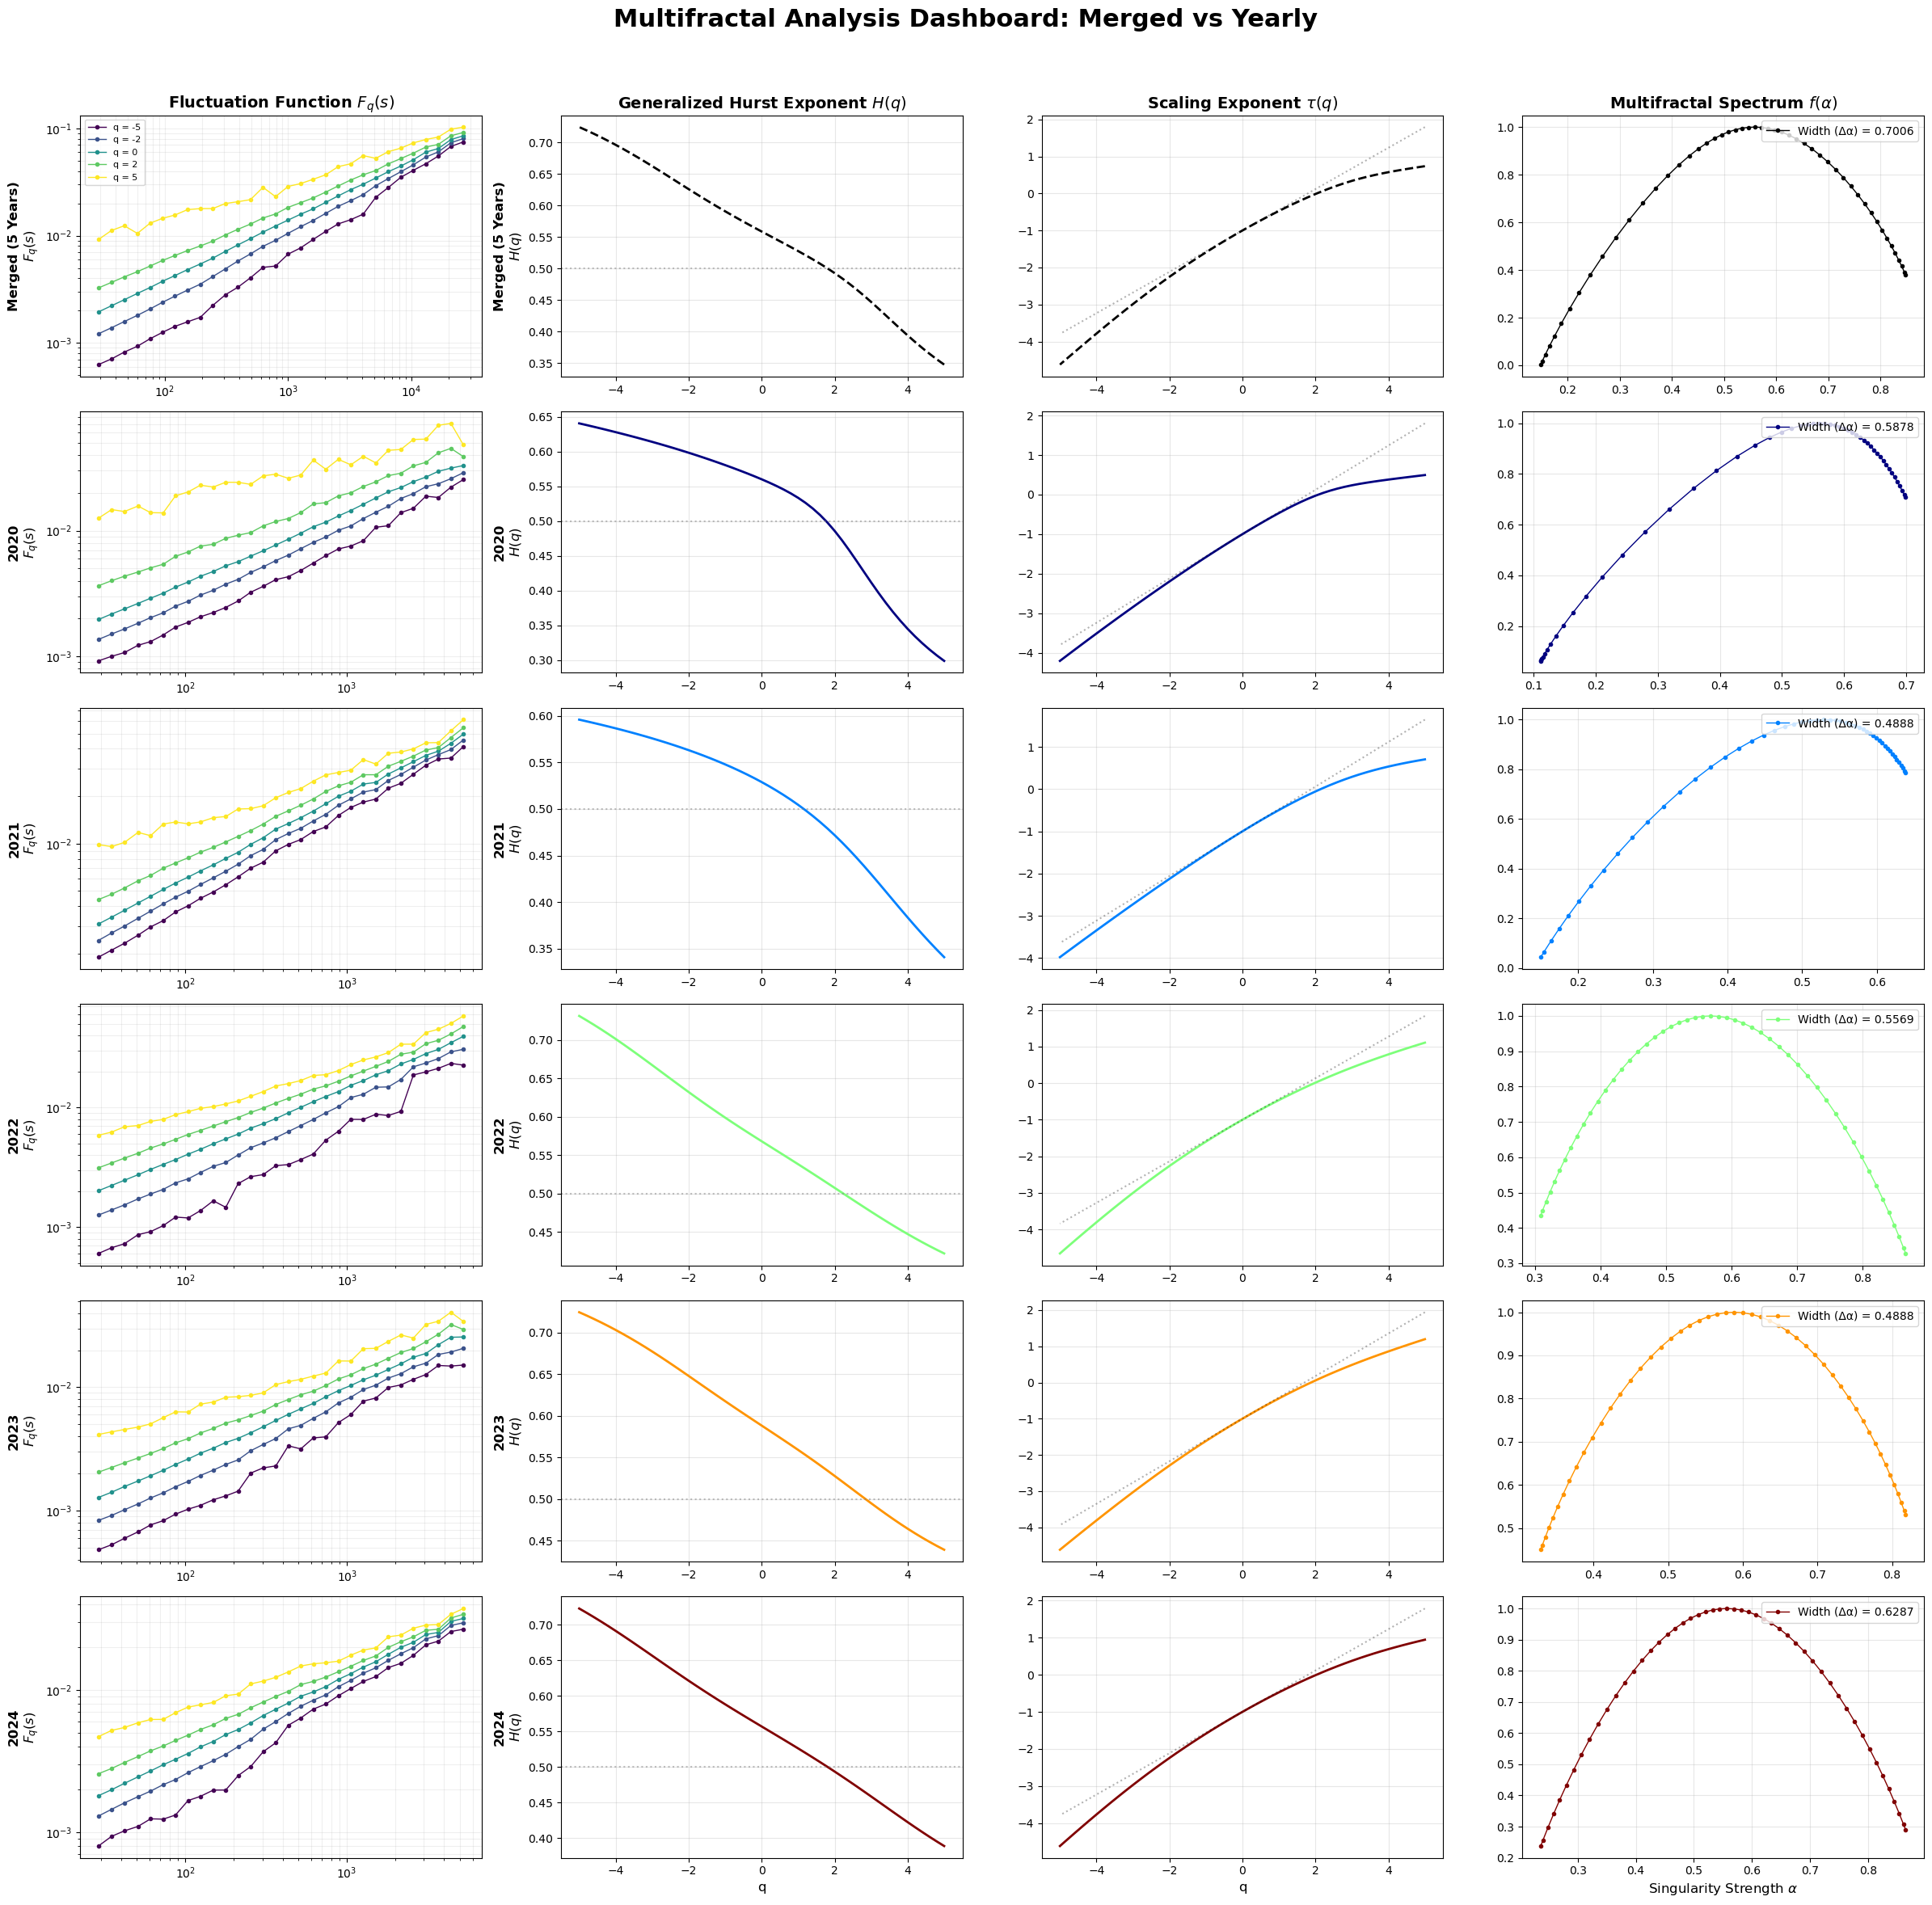

In [7]:
data_dir = "data"
files = sorted(glob.glob(os.path.join(data_dir, "BTCUSDT_10m_*.csv")))

if not files:
    print("No data")
else:
    print(f"Found {len(files)} files")

datasets = {}

for f in files:
    df = pd.read_csv(f, index_col = 'datetime', parse_dates = True)
    if 'return' not in df.columns:
        df['return'] = np.log(df['close']).diff()
    df.dropna(inplace = True)

    year = str(df.index.year[0])
    datasets[year] = df['close']
    print(f"  -> Loaded {year}")

df_all = pd.concat([pd.read_csv(f, index_col = 'datetime', parse_dates = True) for f in files]).sort_index()
if 'return' not in df_all.columns: df_all['return'] = np.log(df_all['close']).diff()
df_all.dropna(inplace = True)
datasets['Merged (5 Years)'] = df_all['close']

keys = sorted([k for k in datasets.keys() if 'Merged' not in k])
keys.insert(0, 'Merged (5 Years)')

q_list = np.linspace(5, -5, 51)
results = {}

print("\n Running MFDFA")
for name in keys:
    res = compute_spectrum(datasets[name], q_list)
    if res: results[name] = res
    print(f"   -> Analyzed {name}")
fig, axes = plt.subplots(len(keys), 4, figsize=(24, 24))
    
    # 전체 제목
plt.subplots_adjust(top=0.95, wspace = 0.3, hspace = 0.4)
fig.suptitle('Multifractal Analysis Dashboard: Merged vs Yearly', fontsize=22, fontweight='bold')
    
    # 색상 맵 (Merged는 검정, 연도는 다채롭게)
cmap = plt.cm.jet(np.linspace(0, 1, len(keys)-1))
q_plots = [-5, -2, 0, 2, 5]
colors_q = plt.cm.viridis(np.linspace(0, 1, len(q_plots)))
    
for i, name in enumerate(keys):
    res = results[name]
        
        # 색상 설정
    if 'Merged' in name:
        color = 'black'
        style = '--'
    else:
        color = cmap[i-1]
        style = '-'
        
    ax0 = axes[i, 0]
    for j, qv in enumerate(q_plots):
        idx = np.argmin(np.abs(q_list - qv))
        ax0.loglog(res['scales'], res['F_q_s'][idx, :], 'o-',
                   color = colors_q[j], markersize = 3, linewidth = 1, label = f'q = {qv}')
        
    ax0.grid(True, which = 'both', alpha = 0.2)
    ax0.set_ylabel(f"{name}\n$F_q(s)$", fontsize = 12, fontweight = 'bold')
    
    if i == 0:
        ax0.set_title("Fluctuation Function $F_q(s)$", fontsize = 14, fontweight = 'bold')
        ax0.legend(fontsize = 8, loc = 'upper left')
            
        # --- (Col 1) H(q) ---
    ax1 = axes[i, 1]
    ax1.plot(q_list, res['H_q'], linestyle=style, color=color, linewidth=2)
    ax1.axhline(0.5, color='gray', linestyle=':', alpha=0.5)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylabel(f"{name}\n$H(q)$", fontsize=12, fontweight='bold')
    if i == 0: ax1.set_title("Generalized Hurst Exponent $H(q)$", fontsize=14, fontweight='bold')
        
        # --- (Col 2) tau(q) ---
    ax2 = axes[i, 2]
    ax2.plot(q_list, res['tau_q'], linestyle=style, color=color, linewidth=2)
        
        # Monofractal Reference Line (비교용 점선)
    h2 = res['H_q'][len(q_list)//2] # q=0 근처의 H값 사용
    ax2.plot(q_list, q_list * h2 - 1, 'k:', alpha=0.3, label='Linear Fit')
        
    ax2.grid(True, alpha=0.3)
    if i == 0: ax2.set_title("Scaling Exponent $\\tau(q)$", fontsize=14, fontweight='bold')
        
        # --- (Col 3) f(alpha) ---
    ax3 = axes[i, 3]
        # 스펙트럼 너비(Width) 표시
    label_txt = f"Width (Δα) = {res['delta_alpha']:.4f}"
    ax3.plot(res['alpha'], res['f_alpha'], 'o-', markersize=3, color=color, linewidth=1, label=label_txt)
        
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc='upper right', fontsize=10, frameon=True)
    if i == 0: ax3.set_title("Multifractal Spectrum $f(\\alpha)$", fontsize=14, fontweight='bold')
        
        # X축 라벨은 맨 마지막 행에만 표시
    if i == len(keys) - 1:
        ax1.set_xlabel('q', fontsize=12)
        ax2.set_xlabel('q', fontsize=12)
        ax3.set_xlabel('Singularity Strength $\\alpha$', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Loading Datasets...
   -> Loaded 2020
   -> Loaded 2021
   -> Loaded 2022
   -> Loaded 2023
   -> Loaded 2024

START EXPERIMENT: 2020
   [Step 1] Extracting MFDFA Features (52703 rows)...
[INFO] Extracting MFDFA Features (Window: 4320)


100%|██████████| 336/336 [00:00<00:00, 362.45it/s]
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008512. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


   [Step 2] Running GARCH-MIDAS...
[INFO] Running GARCH-MIDAS
   [Step 3] Preparing LSTM Data...
   [Step 4] Training LSTM (252 samples)...
   [Result] RMSE (GM): 0.4753 -> (Hybrid): 0.3834 | Improv: 19.33%


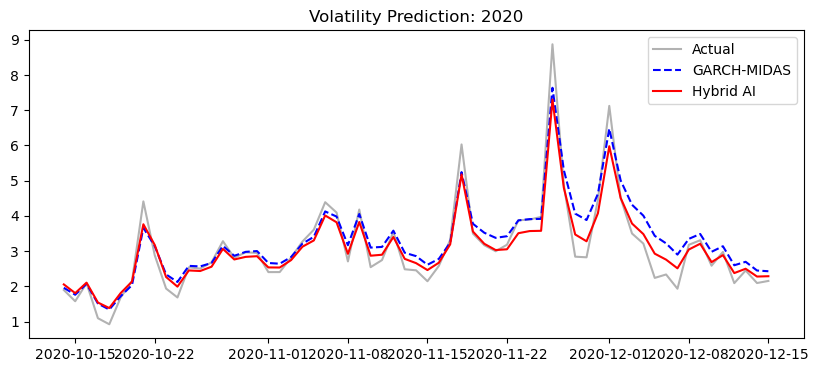


START EXPERIMENT: 2021
   [Step 1] Extracting MFDFA Features (52559 rows)...
[INFO] Extracting MFDFA Features (Window: 4320)


100%|██████████| 335/335 [00:01<00:00, 325.72it/s]
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008069. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


   [Step 2] Running GARCH-MIDAS...
[INFO] Running GARCH-MIDAS
   [Step 3] Preparing LSTM Data...
   [Step 4] Training LSTM (252 samples)...
   [Result] RMSE (GM): 0.5039 -> (Hybrid): 0.4490 | Improv: 10.91%


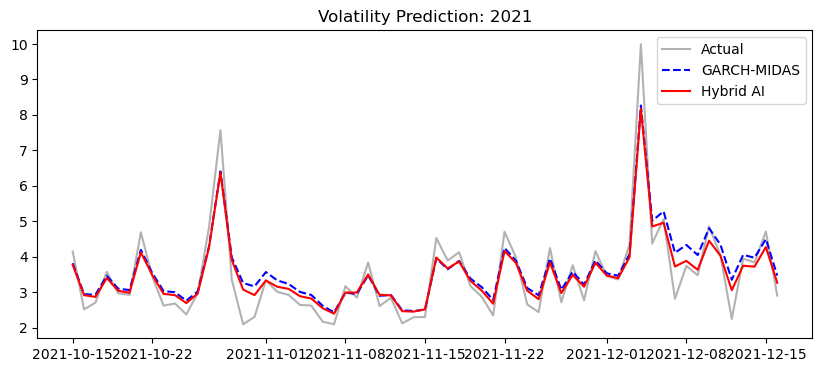


START EXPERIMENT: 2022
   [Step 1] Extracting MFDFA Features (52559 rows)...
[INFO] Extracting MFDFA Features (Window: 4320)


100%|██████████| 335/335 [00:00<00:00, 382.65it/s]
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007602. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


   [Step 2] Running GARCH-MIDAS...
[INFO] Running GARCH-MIDAS
   [Step 3] Preparing LSTM Data...
   [Step 4] Training LSTM (252 samples)...
   [Result] RMSE (GM): 0.3576 -> (Hybrid): 0.2721 | Improv: 23.92%


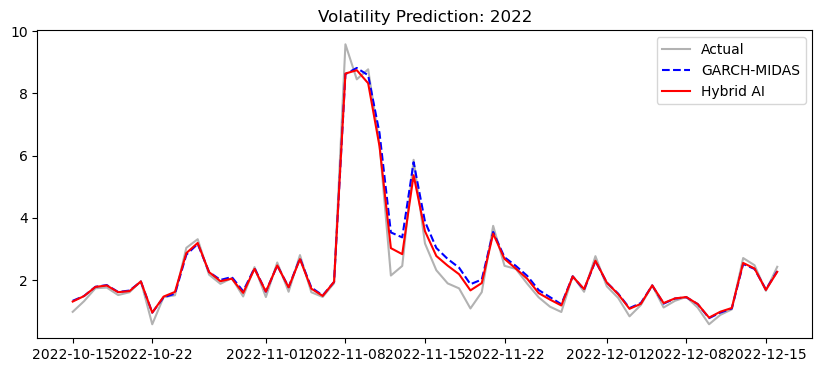


START EXPERIMENT: 2023
   [Step 1] Extracting MFDFA Features (52559 rows)...
[INFO] Extracting MFDFA Features (Window: 4320)


100%|██████████| 335/335 [00:00<00:00, 351.45it/s]
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008565. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


   [Step 2] Running GARCH-MIDAS...
[INFO] Running GARCH-MIDAS
   [Step 3] Preparing LSTM Data...
   [Step 4] Training LSTM (252 samples)...
   [Result] RMSE (GM): 0.1811 -> (Hybrid): 0.1837 | Improv: -1.46%


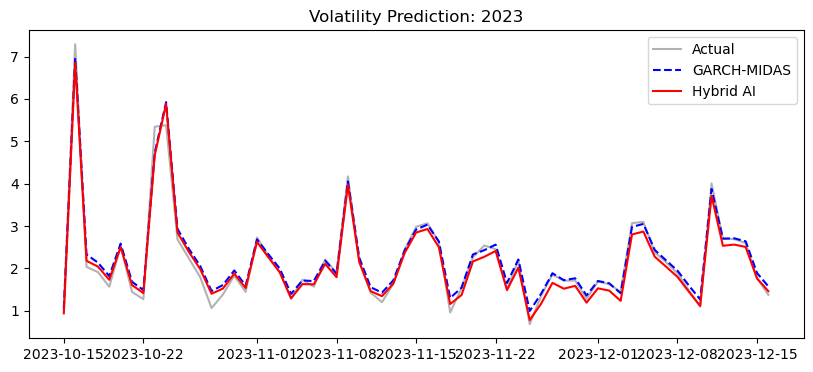


START EXPERIMENT: 2024
   [Step 1] Extracting MFDFA Features (52703 rows)...
[INFO] Extracting MFDFA Features (Window: 4320)


100%|██████████| 336/336 [00:01<00:00, 320.72it/s]
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.007663. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


   [Step 2] Running GARCH-MIDAS...
[INFO] Running GARCH-MIDAS
   [Step 3] Preparing LSTM Data...
   [Step 4] Training LSTM (252 samples)...
   [Result] RMSE (GM): 0.4303 -> (Hybrid): 0.4067 | Improv: 5.48%


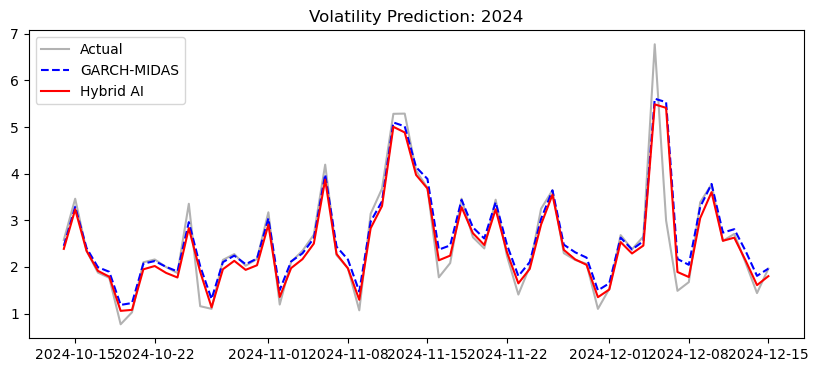


START EXPERIMENT: Merged (5 Years)
   [Step 1] Extracting MFDFA Features (263087 rows)...
[INFO] Extracting MFDFA Features (Window: 4320)


100%|██████████| 1797/1797 [00:04<00:00, 422.09it/s]
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008219. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


   [Step 2] Running GARCH-MIDAS...
[INFO] Running GARCH-MIDAS
   [Step 3] Preparing LSTM Data...
   [Step 4] Training LSTM (1429 samples)...
   [Result] RMSE (GM): 0.4557 -> (Hybrid): 0.3755 | Improv: 17.59%


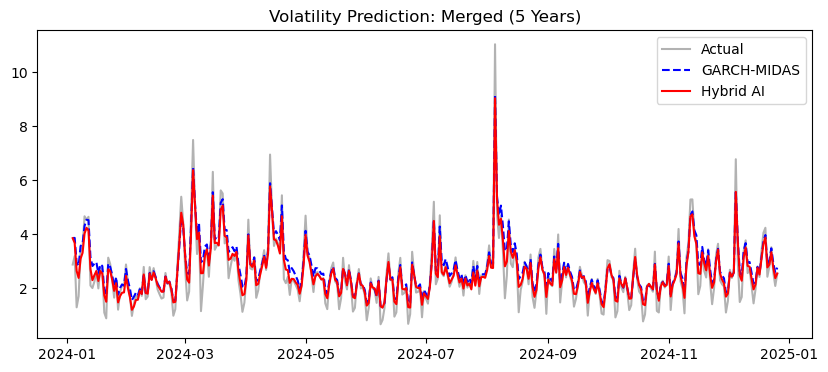


FINAL PERFORMANCE SUMMARY
         Dataset  RMSE_Base  RMSE_Hybrid  MAE_Hybrid  Improvement(%)
            2020     0.4753       0.3834      0.2739         19.3295
            2021     0.5039       0.4490      0.3338         10.9065
            2022     0.3576       0.2721      0.1910         23.9169
            2023     0.1811       0.1837      0.1425         -1.4598
            2024     0.4303       0.4067      0.2228          5.4788
Merged (5 Years)     0.4557       0.3755      0.2737         17.5919


In [8]:

def run_hybrid_experiment(name, df_data):
    print(f"\n{'='*60}")
    print(f"START EXPERIMENT: {name}")
    print(f"{'='*60}")
    
    if 'return' not in df_data.columns:
        df_data['return'] = np.log(df_data['close']).diff() * 100
    df_data.dropna(inplace=True)
    
    daily_rv = (df_data['return']**2).resample('1D').sum().to_frame('rv')
    
    candles_per_day = 144
    window_days = 30
    window_size = window_days * candles_per_day
    
    print(f"   [Step 1] Extracting MFDFA Features ({len(df_data)} rows)...")
    mfdfa_df = mfdfa_features(df_data['close'], DEVICE, window=window_size, step=candles_per_day)
    
    if len(mfdfa_df) == 0:
        print("   [Skip] MFDFA 결과 없음 (데이터 부족)")
        return None

    # [수정 2] 안전하게 Datetime으로 변환 후 normalize 수행
    # 혹시 인덱스가 문자열이나 일반 객체로 되어있을 경우를 대비해 pd.to_datetime() 사용
    mfdfa_df.index = pd.to_datetime(mfdfa_df.index)
    mfdfa_df.index = mfdfa_df.index.normalize()
    
    if len(mfdfa_df) == 0:
        print("   [Skip] MFDFA 결과 없음 (데이터 부족)")
        return None

    print("   [Step 2] Running GARCH-MIDAS...")
    df_gm = garch_midas(df_data, daily_rv)
    
    print("   [Step 3] Preparing LSTM Data...")
    try:
        X, y, scaler_y, dates, raw_data = prepare_lstm_data(df_gm, mfdfa_df, lookback=5)
    except ValueError as e:
        print(f"   [Skip] 데이터 병합 실패: {e}")
        return None
        
    split = int(len(X) * 0.8)
    X_train = torch.FloatTensor(X[:split]).to(DEVICE)
    y_train = torch.FloatTensor(y[:split]).to(DEVICE)
    X_test = torch.FloatTensor(X[split:]).to(DEVICE)
    
    print(f"   [Step 4] Training LSTM ({len(X_train)} samples)...")
    model = ResidualLSTM(input_dim=X.shape[2]).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    loss_fn = nn.MSELoss()
    
    EPOCHS = 150
    model.train()
    
    for epoch in range(EPOCHS):
        optimizer.zero_grad()
        pred = model(X_train)
        loss = loss_fn(pred, y_train)
        loss.backward()
        optimizer.step()
        
    model.eval()
    with torch.no_grad():
        pred_resid_scaled = model(X_test).cpu().numpy()
        
    pred_resid = scaler_y.inverse_transform(pred_resid_scaled)
    
    test_dates = dates[split:]
    final_df = pd.DataFrame(index=test_dates)
    final_df['Actual_Vol'] = raw_data.loc[test_dates, 'Actual_Vol']
    final_df['GM_Vol'] = raw_data.loc[test_dates, 'GM_Vol']
    final_df['Hybrid_Pred'] = final_df['GM_Vol'] + pred_resid.flatten()
    
    rmse_gm = np.sqrt(mean_squared_error(final_df['Actual_Vol'], final_df['GM_Vol']))
    rmse_hybrid = np.sqrt(mean_squared_error(final_df['Actual_Vol'], final_df['Hybrid_Pred']))
    mae_hybrid = mean_absolute_error(final_df['Actual_Vol'], final_df['Hybrid_Pred'])
    improvement = (rmse_gm - rmse_hybrid) / rmse_gm * 100
    
    print(f"   [Result] RMSE (GM): {rmse_gm:.4f} -> (Hybrid): {rmse_hybrid:.4f} | Improv: {improvement:.2f}%")
    
    plt.figure(figsize=(10, 4))
    plt.plot(final_df.index, final_df['Actual_Vol'], 'k-', alpha=0.3, label='Actual')
    plt.plot(final_df.index, final_df['GM_Vol'], 'b--', label='GARCH-MIDAS')
    plt.plot(final_df.index, final_df['Hybrid_Pred'], 'r-', label='Hybrid AI')
    plt.title(f"Volatility Prediction: {name}")
    plt.legend()
    plt.show()
    
    return {
        'Dataset': name,
        'RMSE_Base': rmse_gm,
        'RMSE_Hybrid': rmse_hybrid,
        'MAE_Hybrid': mae_hybrid,
        'Improvement(%)': improvement
    }


data_dir = "data"
files = sorted(glob.glob(os.path.join(data_dir, "BTCUSDT_10m_*.csv")))

if not files:
    print("데이터 파일이 없습니다.")
else:
    datasets = {}
    df_list = []
    
    print("Loading Datasets...")
    for f in files:
        df = pd.read_csv(f, index_col='datetime', parse_dates=True)
        year = str(df.index.year[0])
        datasets[year] = df
        df_list.append(df)
        print(f"   -> Loaded {year}")
        
    df_all = pd.concat(df_list).sort_index()
    datasets['Merged (5 Years)'] = df_all
    
    keys = sorted([k for k in datasets.keys() if 'Merged' not in k]) + ['Merged (5 Years)']
    
    summary_results = []
    
    for name in keys:
        df_target = datasets[name].copy()
        
        res = run_hybrid_experiment(name, df_target)
        if res:
            summary_results.append(res)
            
    print("\n" + "="*60)
    print("FINAL PERFORMANCE SUMMARY")
    print("="*60)
    summary_df = pd.DataFrame(summary_results)
    print(summary_df.to_string(index=False, float_format=lambda x: "{:.4f}".format(x)))
    print("="*60)

In [9]:
if __name__ == "__main__":
    # 데이터셋 존재 여부 확인
    if 'datasets' in locals() and 'Merged (5 Years)' in datasets:
        # 1. 데이터 로드 및 수익률 계산
        target_df = datasets['Merged (5 Years)'][['close']].copy()
        if 'return' not in target_df.columns:
            target_df['return'] = np.log(target_df['close']).diff() * 100
        target_df.dropna(inplace=True)
        
        # 2. Base Model (GARCH-MIDAS) 실행
        df_base = monthly_garch_midas(target_df)
        
        # 3. MF-DFA 추출 (메모리에 없으면 실행 - 시간 소요 주의)
        if 'mfdfa_df' not in locals():
            print("⚠️ MF-DFA 데이터가 없어 새로 계산합니다. (오래 걸릴 수 있음)")
            # step=1 (10분 단위), window=4320 (30일)
            mfdfa_df = mfdfa_features(target_df['close'], DEVICE, window=30*144, step=1)
            
        # 4. Feature Flattening (회귀분석형 데이터셋 생성)
        # lags=144: 과거 24시간 데이터를 옆으로 펼칩니다.
        flat_data, features = prepare_flatten_features(df_base, mfdfa_df, lags=144)
        
        # 5. Rolling Simulation 실행
        # 학습 윈도우: 30일 (4320개)
        final_result = run_rolling_flatten_lstm(flat_data, features, train_window=4320)
        
        # 6. 결과 평가 (RMSE, MAE, Improvement)
        eval_df = final_result.dropna()
        
        rmse_base = np.sqrt(mean_squared_error(eval_df['Future_Vol_24h'], eval_df['Base_Vol']))
        rmse_hybrid = np.sqrt(mean_squared_error(eval_df['Future_Vol_24h'], eval_df['Hybrid_Vol']))
        mae_hybrid = mean_absolute_error(eval_df['Future_Vol_24h'], eval_df['Hybrid_Vol'])
        
        improvement = (rmse_base - rmse_hybrid) / rmse_base * 100
        
        print("\n" + "="*60)
        print(f"🏆 FINAL HYBRID MODEL RESULT")
        print("="*60)
        print(f" RMSE (Base GARCH) : {rmse_base:.4f}")
        print(f" RMSE (Hybrid LSTM): {rmse_hybrid:.4f}")
        print(f" 개선율 (Improvement): {improvement:.2f}%")
        print("-" * 60)
        print(f" MAE (Hybrid)      : {mae_hybrid:.4f}")
        print("="*60)
        
        # 7. 결과 시각화
        plt.figure(figsize=(15, 6))
        plt.plot(eval_df.index, eval_df['Future_Vol_24h'], 'k-', alpha=1.0, label='Actual 24h Volatility')
        plt.plot(eval_df.index, eval_df['Base_Vol'], 'b--', linewidth=0.5,label='Base (GARCH-MIDAS)')
        plt.plot(eval_df.index, eval_df['Hybrid_Vol'], 'r-', linewidth=0.5, label='Hybrid (LSTM Corrected)')
        plt.title("Adaptive Hybrid Prediction: GARCH + Rolling Flattened LSTM")
        plt.legend()
        plt.grid(True, alpha=0.2)
        plt.show()
        
    else:
        print("❌ 오류: 'datasets' 변수가 로드되지 않았습니다. Step 1 데이터 로드 코드를 먼저 실행해주세요.")

[INFO] Base Model Running (GARCH-MIDAS)


Monthly Re-fitting:   0%|          | 0/54 [00:00<?, ?it/s]

[INFO] Running GARCH-MIDAS
[INFO] Running GARCH-MIDAS


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled,

[INFO] Running GARCH-MIDAS


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled,

[INFO] Running GARCH-MIDAS


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled,

[INFO] Running GARCH-MIDAS


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled,

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  11%|█         | 6/54 [00:00<00:05,  9.24it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages\

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  13%|█▎        | 7/54 [00:00<00:05,  8.48it/s]

[INFO] Running GARCH-MIDAS


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled,

[INFO] Running GARCH-MIDAS
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  19%|█▊        | 10/54 [00:01<00:06,  7.15it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  22%|██▏       | 12/54 [00:01<00:05,  7.04it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  26%|██▌       | 14/54 [00:01<00:06,  6.50it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS
[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  30%|██▉       | 16/54 [00:02<00:06,  5.46it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  31%|███▏      | 17/54 [00:02<00:07,  5.09it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  33%|███▎      | 18/54 [00:02<00:07,  4.58it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  35%|███▌      | 19/54 [00:03<00:08,  4.15it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  37%|███▋      | 20/54 [00:03<00:08,  3.81it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  39%|███▉      | 21/54 [00:03<00:10,  3.29it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  41%|████      | 22/54 [00:04<00:10,  3.04it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  43%|████▎     | 23/54 [00:04<00:09,  3.20it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  44%|████▍     | 24/54 [00:04<00:10,  2.76it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  46%|████▋     | 25/54 [00:05<00:16,  1.74it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  48%|████▊     | 26/54 [00:06<00:15,  1.84it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  50%|█████     | 27/54 [00:06<00:14,  1.92it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  52%|█████▏    | 28/54 [00:07<00:13,  1.97it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  54%|█████▎    | 29/54 [00:08<00:16,  1.48it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  56%|█████▌    | 30/54 [00:09<00:17,  1.34it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  57%|█████▋    | 31/54 [00:10<00:16,  1.36it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  59%|█████▉    | 32/54 [00:10<00:15,  1.42it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  61%|██████    | 33/54 [00:11<00:15,  1.38it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  63%|██████▎   | 34/54 [00:12<00:14,  1.42it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  65%|██████▍   | 35/54 [00:12<00:12,  1.51it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  67%|██████▋   | 36/54 [00:13<00:12,  1.45it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  69%|██████▊   | 37/54 [00:14<00:12,  1.41it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  70%|███████   | 38/54 [00:14<00:11,  1.41it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  72%|███████▏  | 39/54 [00:15<00:11,  1.35it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  74%|███████▍  | 40/54 [00:16<00:10,  1.34it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  76%|███████▌  | 41/54 [00:17<00:09,  1.31it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  78%|███████▊  | 42/54 [00:17<00:08,  1.35it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  80%|███████▉  | 43/54 [00:18<00:07,  1.39it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  81%|████████▏ | 44/54 [00:19<00:07,  1.27it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  83%|████████▎ | 45/54 [00:20<00:06,  1.29it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  85%|████████▌ | 46/54 [00:21<00:06,  1.32it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  87%|████████▋ | 47/54 [00:21<00:05,  1.33it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  89%|████████▉ | 48/54 [00:22<00:05,  1.16it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  91%|█████████ | 49/54 [00:23<00:04,  1.19it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  93%|█████████▎| 50/54 [00:24<00:03,  1.04it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  94%|█████████▍| 51/54 [00:27<00:04,  1.37s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  96%|█████████▋| 52/54 [00:30<00:03,  1.79s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting:  98%|█████████▊| 53/54 [00:32<00:01,  1.98s/it]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau'] = daily_rv['rv'].rolling(midas_k).apply(lambda x: np.dot(x, weights[::-1]), raw = True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\1670735467.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_rv['tau_pred'] = daily_rv['tau'].shift(1)
c:\Users\kjw02\anaconda3\Lib\site-packages

[INFO] Running GARCH-MIDAS


Monthly Re-fitting: 100%|██████████| 54/54 [00:34<00:00,  1.55it/s]


Complete 232560 Created
⚠️ MF-DFA 데이터가 없어 새로 계산합니다. (오래 걸릴 수 있음)
[INFO] Extracting MFDFA Features (Window: 4320)


100%|██████████| 258766/258766 [25:24<00:00, 169.74it/s]
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\2133416000.py:65: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_base['Base_Vol'] = df_base['gm_vol'].fillna(method = 'ffill')


Data Preprocessing: Create Lag Variables (Lags = 144)


Create past data columns:  11%|█         | 16/144 [00:00<00:00, 150.53it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\2133416000.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\2133416000.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col_name] = data[col].shift(lag)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15188\2133416000.py:84: PerformanceWarning: DataFrame is highly fragmented.

Final Data shape: (232272, 872)
The Number of variables in Model: 864

[INFO] Rolling Simulation Start


Rolling Update:  55%|█████▌    | 125709/227952 [2:32:23<2:03:56, 13.75it/s] 


KeyboardInterrupt: 

In [1]:
import torch
try:
    import intel_extension_for_pytorch as ipex
    print("✅ IPEX Import 성공!")
except ImportError:
    print("❌ IPEX Import 실패 (설치 확인 필요)")

if hasattr(torch, 'xpu') and torch.xpu.is_available():
    print(f"✅ Intel Arc GPU Detected: {torch.xpu.get_device_name(0)}")
else:
    print("⚠️ Intel GPU not found. (드라이버 문제이거나 재부팅 필요할 수 있음)")

OSError: [WinError 126] 지정된 모듈을 찾을 수 없습니다. Error loading "c:\Users\kjw02\anaconda3\Lib\site-packages\torch\lib\backend_with_compiler.dll" or one of its dependencies.